In [32]:
### Library Import Initialization
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


In [33]:
### Load in Stock Data
def import_stock_data(tickers, start_date):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = yf.download(tickers, start_date)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = yf.download(tickers, start_date)['Adj Close']
    return data

tickers = 'GOOG'
start_data = '2022-01-01'
stock_data = import_stock_data(tickers, start_data)
# Get most recent stock price
S_0 = stock_data.iloc[1, -1]
S_0

[*********************100%%**********************]  1 of 1 completed


144.41650390625

In [34]:
### Compute Log Returns
def get_log_returns(data):
    return np.log(stock_data / stock_data.shift(1))

log_returns = get_log_returns(stock_data)
log_returns.tail()

,GOOG
Date,
2024-05-06,0.004958
2024-05-07,0.018378
2024-05-08,-0.010577
2024-05-09,0.002451
2024-05-10,-0.007547


In [35]:
### Calculate Historical Volatility
def volatility(log_returns):
    # Calculate standard deviation of log_returns
    std_dev = log_returns.std()
    # Calculate historical volatility (v_0) = sqrt(252) * std dev
    v_0 = np.sqrt(252) * std_dev # 252 trading days per year

    return v_0

v_0 = volatility(log_returns)
v_0

GOOG    0.34456
dtype: float64

In [36]:
### Initialize Parameters
# Mean-reversion speed in the Heston model
k = 0.1  
# Volatility of volatility in the Heston model
sigma = 0.2  
# Time step, typically representing trading days in a year
dt = 252  
# Long-term average variance (squared volatility) in the Heston model
theta = v_0 ** 2  
# Drift rate, computed as mean - 0.5 * variance
mean = log_returns.mean()  
var = log_returns.var()  
drift = mean - (0.5 * var)  


In [37]:
### Heston Model Function
def heston_model(S_0, v_0, drift, k, theta, sigma, dt, days):
    # Generate random numbers z_1​ and z_2​ from a standard normal distribution for each time step
    z_1 = np.random.randn(days)
    z_2 = np.random.randn(days)
    
    # Create empty lists to store asset prices
    S = np.zeros(days)
    v = np.zeros(days)
    # Set first value of array to initial S_0 and v_0 
    S[0] = S_0
    v[0] = v_0

    # Loop through each time step starting from t=1
    for t in range(1, days):
        # Update asset price S[t] using the Heston model equation
        S[t] = S[t-1] * np.exp((drift - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * z_1[t])
        # Update volatility v[t] using the Heston model equation
        v[t] = v[t-1] + k * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1] * dt) * z_2[t]

    return S



<function matplotlib.pyplot.show(close=None, block=None)>

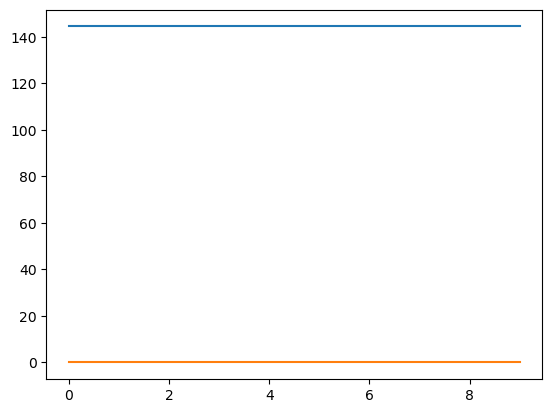

In [39]:
### Generate Price Paths
# Variable init
trials = 10
days = 252
# Initialize price_paths with correct dimensions
price_paths = np.zeros((trials, days))  
# set initial value of price paths to the last stock value
price_paths[0] = S_0

# Loop to calculate each individual path and store it in the price paths array
for trial in range(trials):
    price_paths[trial] = heston_model(S_0, v_0, drift, k, theta, sigma, dt, days)

# Plot each of the 1000 price paths over the 252 day span
plt.plot(price_paths)
plt.show
